In [220]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', size=18)

In [221]:
nano_df = []
for nano_baby in glob.glob("output/ttbar-monolep*"):
    nano_df.append(((uproot.open(nano_baby)).get("tree")).pandas.df())
nano_df = pd.concat(nano_df)

## 1. Sanity Checks

In [222]:
nano_df.columns

Index([u'event', u'ht', u'met', u'deepCSV_btags_loose',
       u'deepCSV_btags_medium', u'deepCSV_btags_tight', u'deepJet_btags_loose',
       u'deepJet_btags_medium', u'deepJet_btags_tight', u'lepton_id',
       u'lepton_pt', u'lepton_pt_corr', u'lepton_eta', u'lepton_phi',
       u'fake_id', u'fake_pt', u'fake_pt_corr', u'fake_eta', u'fake_phi',
       u'fake_unmatched', u'fake_from_b', u'fake_from_c', u'fake_from_light'],
      dtype='object')

In [223]:
fake_els_df = nano_df[nano_df.fake_id.abs() == 11] # Tight single-muon events w/ tight fake electron
fake_mus_df = nano_df[nano_df.fake_id.abs() == 13] # Tight single-muon events w/ tight fake electron

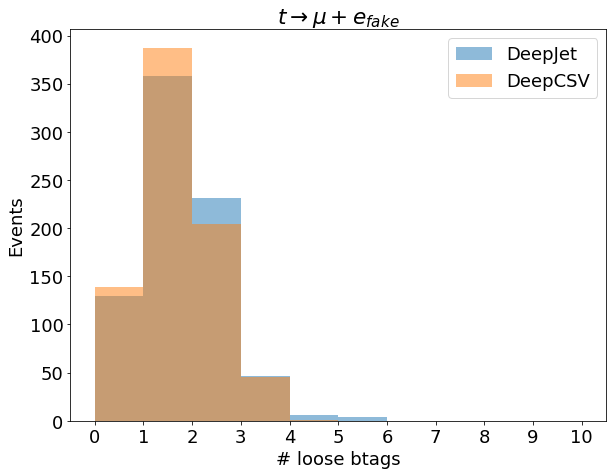

In [224]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_els_df.deepJet_btags_loose, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepJet");
plt.hist(fake_els_df.deepCSV_btags_loose, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepCSV");

plt.legend();
plt.title(r"$t\rightarrow \mu+e_{fake}$");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10]);
plt.xlabel("# loose btags");
plt.ylabel("Events");

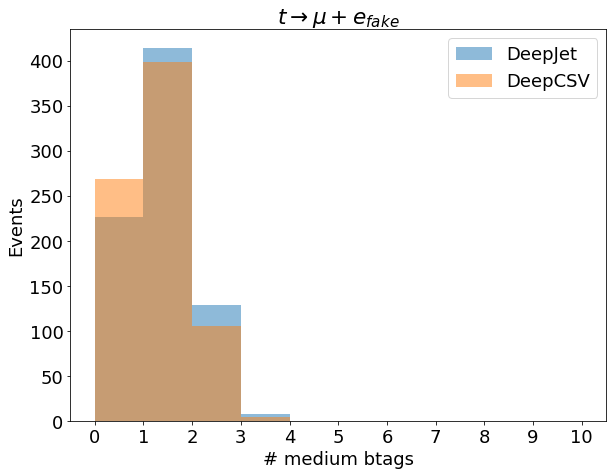

In [225]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_els_df.deepJet_btags_medium, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepJet");
plt.hist(fake_els_df.deepCSV_btags_medium, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepCSV");

plt.legend();
plt.title(r"$t\rightarrow \mu+e_{fake}$");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10]);
plt.xlabel("# medium btags");
plt.ylabel("Events");

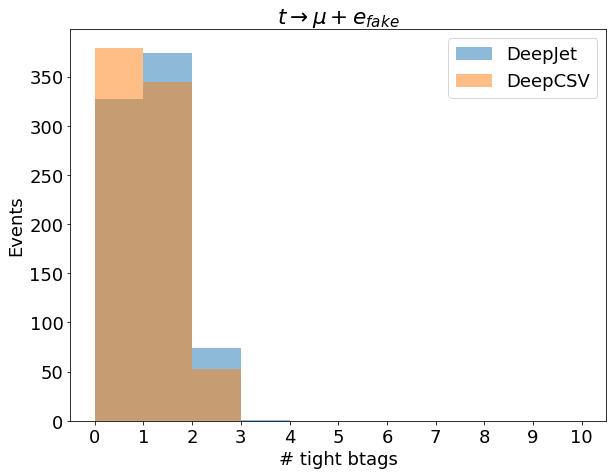

In [226]:
fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
axes = plt.subplot(111)

plt.hist(fake_els_df.deepJet_btags_tight, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepJet");
plt.hist(fake_els_df.deepCSV_btags_tight, bins=[0,1,2,3,4,5,6,7,8,9,10],
         alpha=0.5, label="DeepCSV");

plt.legend();
plt.title(r"$t\rightarrow \mu+e_{fake}$");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10]);
plt.xlabel("# tight btags");
plt.ylabel("Events");

## 2. Plots

In [227]:
def lineage_hist(df, n_btags, algo, wp,
                 fig=None, axes=None, fmt="bo", label="",
                 b_text=True):
    if not fig or not axes:
        fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
        axes = plt.subplot(111)
    # Bin sizes
    bin_edges = np.arange(5)[1:]
    bin_widths = bin_edges[1:]-bin_edges[:-1]
    bin_centers = bin_edges[:-1]+0.5*bin_widths
    # Bin values
    bin_vals = np.zeros(4)
    deepalgo_btags = df["{0}_btags_{1}".format(algo, wp)]
    bin_vals[0] = np.sum(df[deepalgo_btags >= n_btags].fake_from_c)
    bin_vals[1] = np.sum(df[deepalgo_btags >= n_btags].fake_from_b)
    bin_vals[2] = np.sum(df[deepalgo_btags >= n_btags].fake_from_light)
    bin_vals[3] = np.sum(df[deepalgo_btags >= n_btags].fake_unmatched)
    # Plot
    axes.errorbar(bin_edges, bin_vals, xerr=0.5, fmt=fmt, label=label);
    # Marker labels
    if b_text:
        count = int(bin_vals[1]) # bin count for 'from b' bin
        plt.text(2, count+1, # x=2 <--> from b, y=count+1 gives small padding
                 "{0:#d} ({1:0.1f})%".format(count, 100.0*count/np.sum(bin_vals)),
                 horizontalalignment='center')
    # Plot formatting
    plt.xticks(bin_edges, ["c", "b", "light/other", "unmatched"]);
    plt.ylabel("Events");
    plt.grid()
    
def composition_plot(df, algo, wp, fake_particle):
    fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
    axes = plt.subplot(111)
    
    # Check particle name
    title = ""
    if fake_particle == "electron":
        title = r"Composition of Fakes ($t\rightarrow \mu+e_{fake}$)"
    elif fake_particle == "muon":
        title = r"Composition of Fakes ($t\rightarrow e+\mu_{fake}$)"
    else:
        return
    # Get DeepAlgo name
    DeepAlgo = ""
    if algo == "deepCSV":
        DeepAlgo = "DeepCSV"
    elif algo == "deepJet":
        DeepAlgo = "DeepJet"
    else:
        return
    # Hists
    lineage_hist(df, n_btags=0, algo=algo, wp=wp,
                 fig=fig, axes=axes, fmt="bs", label=r"$N_{btags}\geq 0$")
    lineage_hist(df, n_btags=1, algo=algo, wp=wp,
                 fig=fig, axes=axes, fmt="ro", label=r"$N_{btags}\geq 1$")
    lineage_hist(df, n_btags=2, algo=algo, wp=wp,
                 fig=fig, axes=axes, fmt="m^", label=r"$N_{btags}\geq 2$")
    # Plot formatting
    plt.title(title);
    plt.legend(title="{0} ({1})".format(DeepAlgo, wp));
    
def fake_pt_corr_plot(df, algo, wp, fake_particle):
    fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
    axes = plt.subplot(111)
    # Check particle name
    if fake_particle != "electron" and fake_particle != "muon":
        return
    # Get DeepAlgo name
    DeepAlgo = ""
    if algo == "deepCSV":
        DeepAlgo = "DeepCSV"
    elif algo == "deepJet":
        DeepAlgo = "DeepJet"
    else:
        return
    # Hist w/ no cut on nbtags
    plt.hist(df.fake_pt_corr, bins=np.linspace(0,300,31),
             alpha=0.25, histtype="step", fill=True, color="b", linewidth=2,
             label=r"$N_{btags}\geq 0$");
    # Get deepalgo btags
    deepalgo_btags = df["{0}_btags_{1}".format(algo, wp)]
    # Hists w/ cut on nbtags
    plt.hist(df[deepalgo_btags >= 1].fake_pt_corr, bins=np.linspace(0,300,31),
             alpha=0.50, histtype="step", fill=True, color="r", linewidth=2,
             label=r"$N_{btags}\geq 1$");
    plt.hist(df[deepalgo_btags >= 2].fake_pt_corr, bins=np.linspace(0,300,31),
             alpha=0.75, histtype="step", fill=True, color="m", linewidth=2,
             label=r"$N_{btags}\geq 2$");
    # Plot formatting
    plt.title("Fake {}".format(fake_particle+"s"))
    plt.xlabel(r"$p_{T}^{corr}$")
    plt.ylabel("Events")
    plt.legend(title="{0} ({1})".format(DeepAlgo, wp));
    axes.margins(x=0) # Remove x-axis margins
    
def fake_eta_plot(df, algo, wp, fake_particle):
    fig = plt.figure(figsize=(6.4*1.5,4.8*1.5))
    axes = plt.subplot(111)
    # Check particle name
    if fake_particle != "electron" and fake_particle != "muon":
        return
    # Get DeepAlgo name
    DeepAlgo = ""
    if algo == "deepCSV":
        DeepAlgo = "DeepCSV"
    elif algo == "deepJet":
        DeepAlgo = "DeepJet"
    else:
        return
    # Hist w/ no cut on nbtags
    plt.hist(df.fake_eta, bins=np.linspace(-2.5,2.5,21),
             alpha=0.25, histtype="step", fill=True, color="b", linewidth=2,
             label=r"$N_{btags}\geq 0$");
    # Get deepalgo btags
    deepalgo_btags = df["{0}_btags_{1}".format(algo, wp)]
    # Hists w/ cut on nbtags
    plt.hist(df[deepalgo_btags >= 1].fake_eta, bins=np.linspace(-2.5,2.5,21),
             alpha=0.50, histtype="step", fill=True, color="r", linewidth=2,
             label=r"$N_{btags}\geq 1$");
    plt.hist(df[deepalgo_btags >= 2].fake_eta, bins=np.linspace(-2.5,2.5,21),
             alpha=0.75, histtype="step", fill=True, color="m", linewidth=2,
             label=r"$N_{btags}\geq 2$");
    # Plot formatting
    plt.title("Fake {}".format(fake_particle+"s"))
    plt.xticks(np.linspace(-2.5,2.5,11));
    plt.xlabel(r"$\eta$")
    plt.ylabel("Events")
    plt.legend(title="{0} ({1})".format(DeepAlgo, wp));
    axes.margins(x=0) # Remove x-axis margins

## 3. Fake electrons
From several samples of single-lepton $t\bar{t}$, where we require (at the generator level) $t\rightarrow W\rightarrow \mu$, i.e. we truth match to a single-muon event, then require both a tight $\mu$ (prompt) and a tight $e$ (non-prompt) in reco.

### 3.1 Composition of fakes (DeepCSV loose)

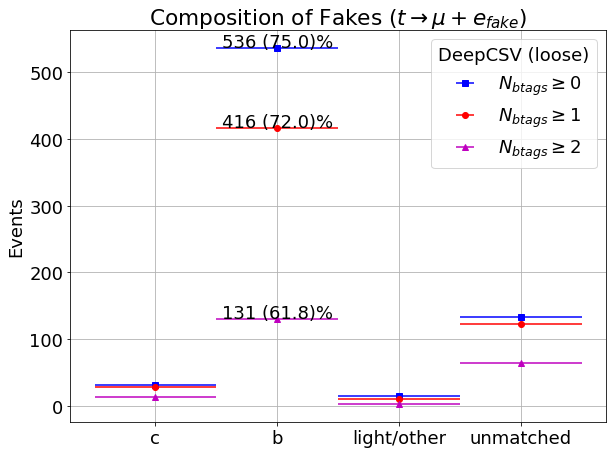

In [228]:
composition_plot(fake_els_df, "deepCSV", "loose", "electron")

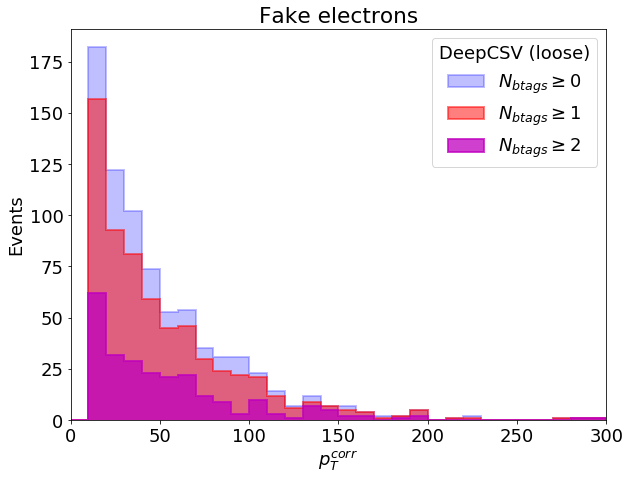

In [229]:
fake_pt_corr_plot(fake_els_df, "deepCSV", "loose", "electron")

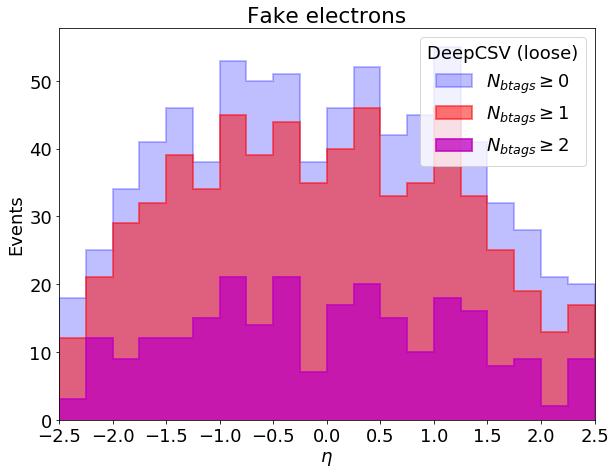

In [230]:
fake_eta_plot(fake_els_df, "deepCSV", "loose", "electron")

### 3.2 Composition of fakes (DeepCSV medium)

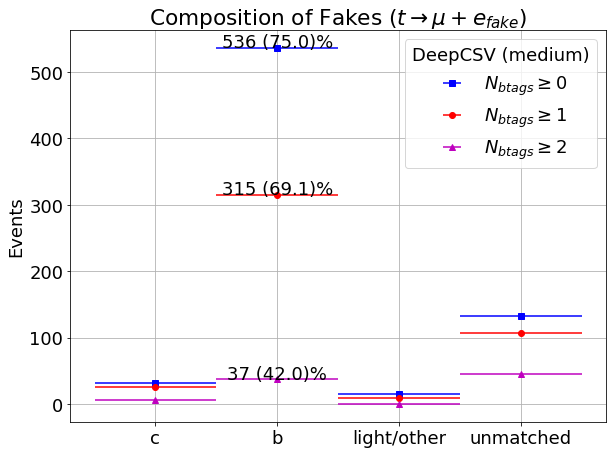

In [231]:
composition_plot(fake_els_df, "deepCSV", "medium", "electron")

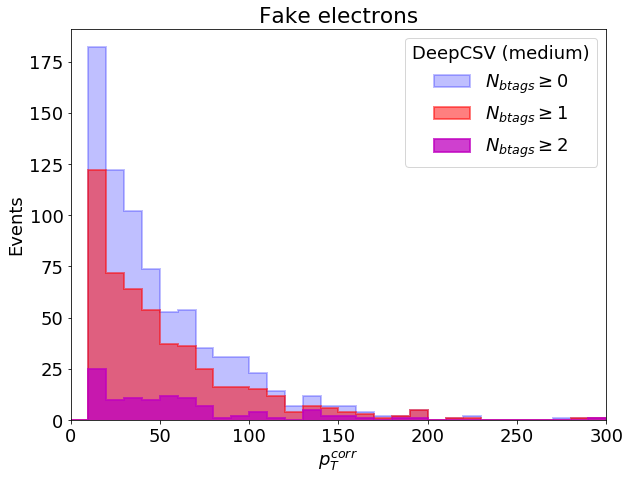

In [232]:
fake_pt_corr_plot(fake_els_df, "deepCSV", "medium", "electron")

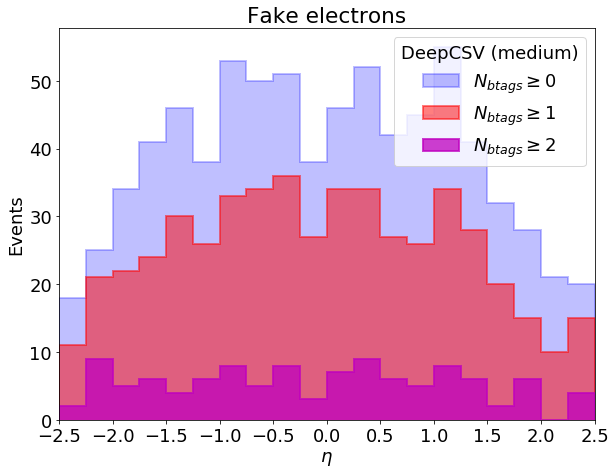

In [233]:
fake_eta_plot(fake_els_df, "deepCSV", "medium", "electron")

### 3.3 Composition of fakes (DeepCSV tight)

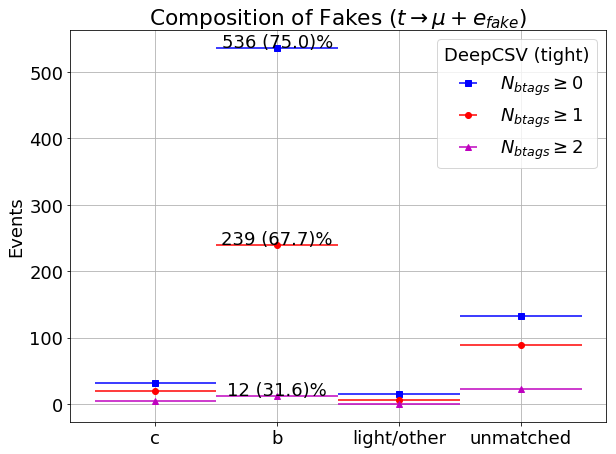

In [234]:
composition_plot(fake_els_df, "deepCSV", "tight", "electron")

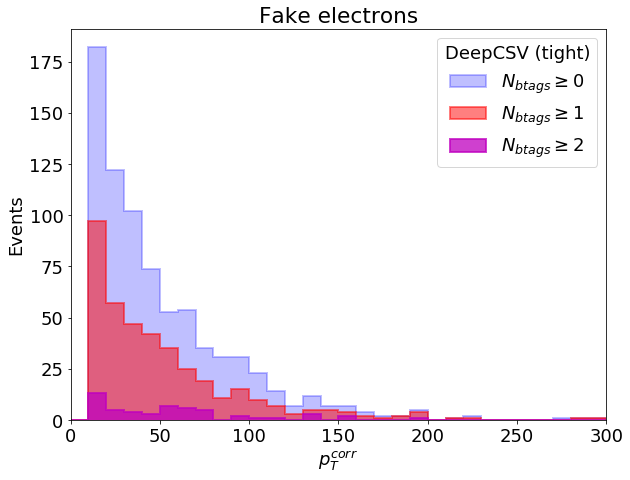

In [235]:
fake_pt_corr_plot(fake_els_df, "deepCSV", "tight", "electron")

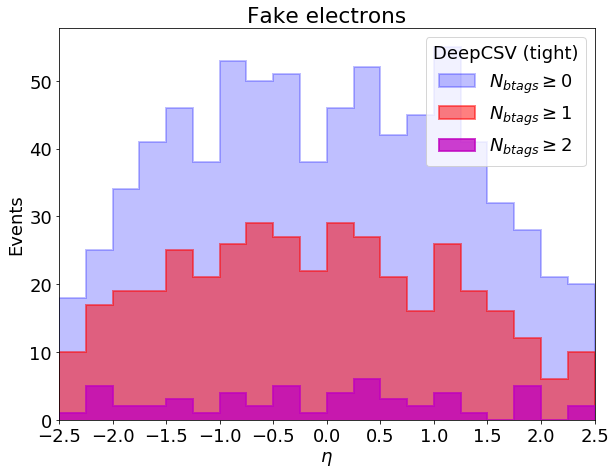

In [236]:
fake_eta_plot(fake_els_df, "deepCSV", "tight", "electron")

### 3.4 Composition of fakes (DeepJet loose)

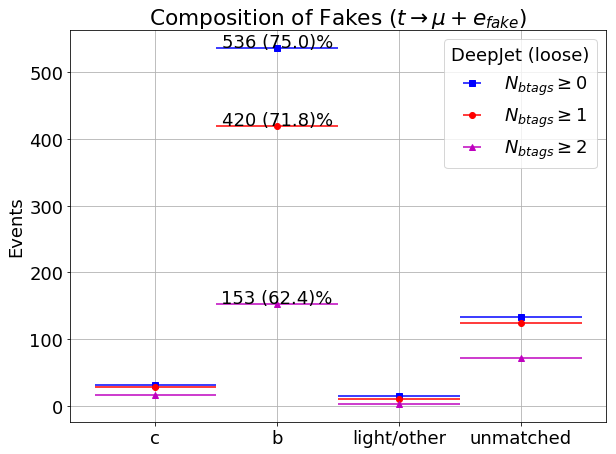

In [237]:
composition_plot(fake_els_df, "deepJet", "loose", "electron")

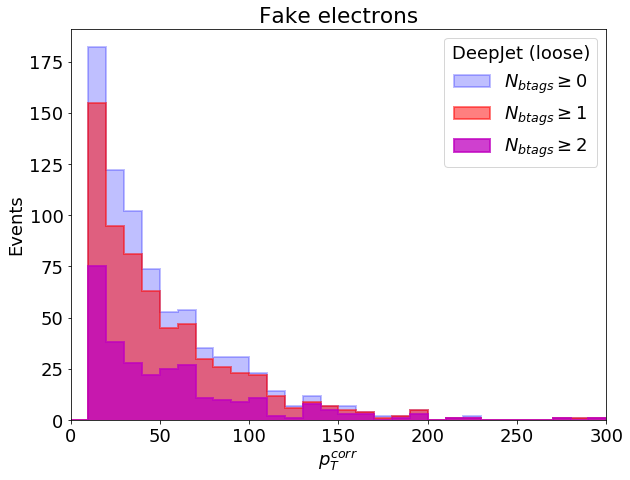

In [238]:
fake_pt_corr_plot(fake_els_df, "deepJet", "loose", "electron")

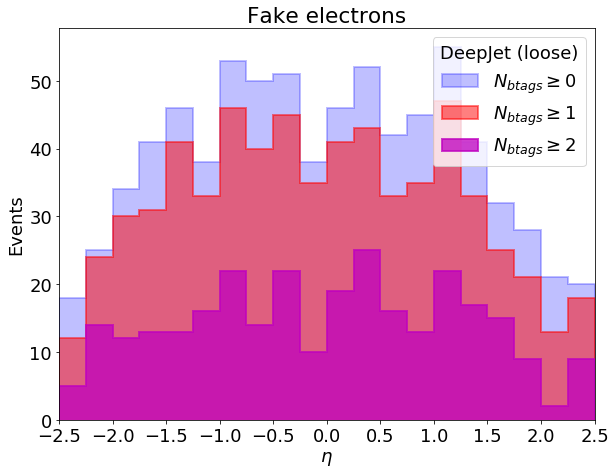

In [239]:
fake_eta_plot(fake_els_df, "deepJet", "loose", "electron")

### 3.5 Composition of fakes (DeepJet medium)

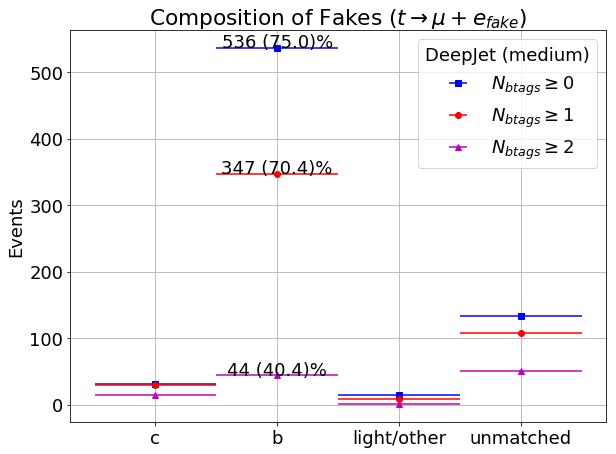

In [240]:
composition_plot(fake_els_df, "deepJet", "medium", "electron")

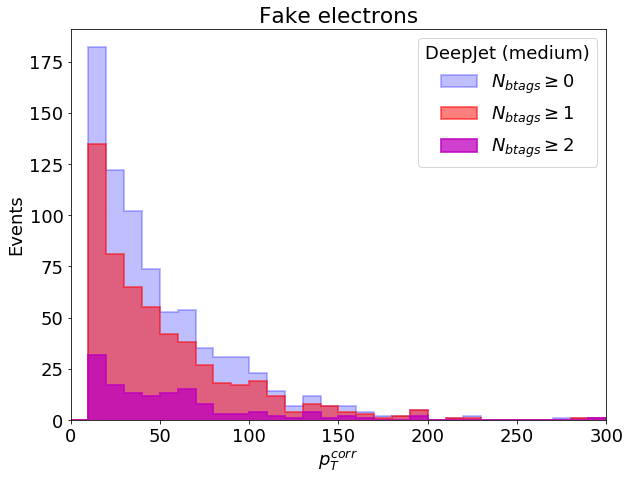

In [241]:
fake_pt_corr_plot(fake_els_df, "deepJet", "medium", "electron")

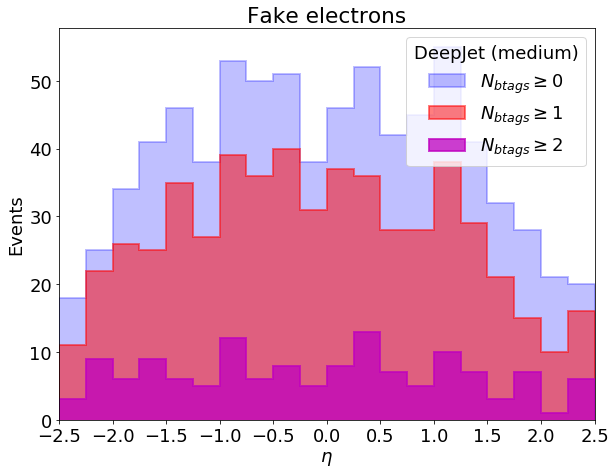

In [242]:
fake_eta_plot(fake_els_df, "deepJet", "medium", "electron")

### 3.6 Composition of fakes (DeepJet tight)

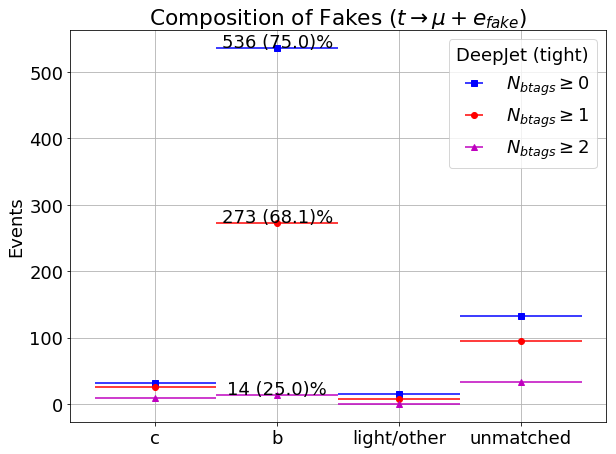

In [243]:
composition_plot(fake_els_df, "deepJet", "tight", "electron")

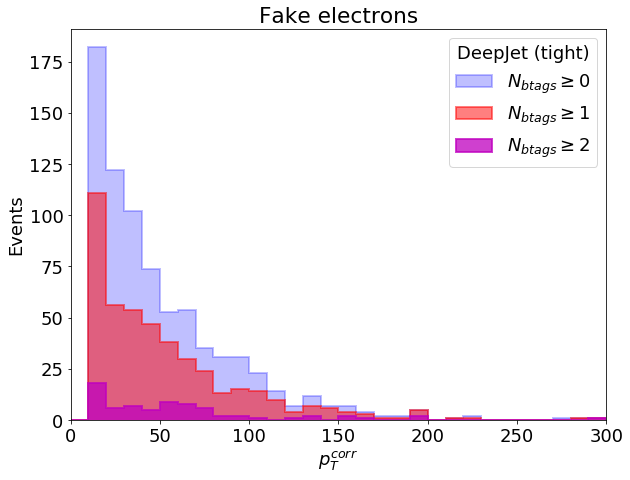

In [244]:
fake_pt_corr_plot(fake_els_df, "deepJet", "tight", "electron")

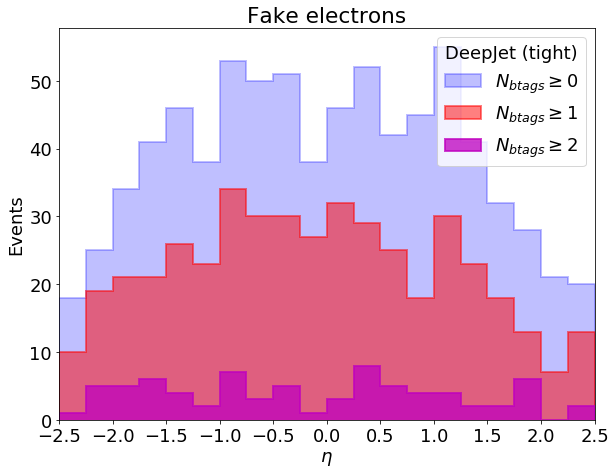

In [245]:
fake_eta_plot(fake_els_df, "deepJet", "tight", "electron")

## 4. Fake muons
From several samples of single-lepton $t\bar{t}$, where we require (at the generator level) $t\rightarrow W\rightarrow e$, i.e. we truth match to a single-electron event, then require both a tight $e$ (prompt) and a tight $\mu$ (non-prompt) in reco.

### 4.1 Composition of fakes (DeepCSV loose)

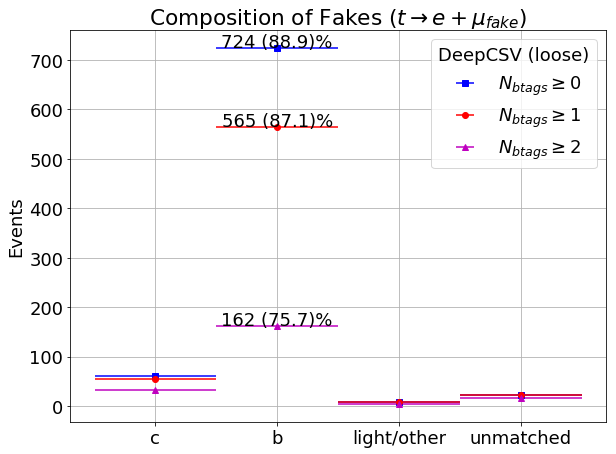

In [246]:
composition_plot(fake_mus_df, "deepCSV", "loose", "muon")

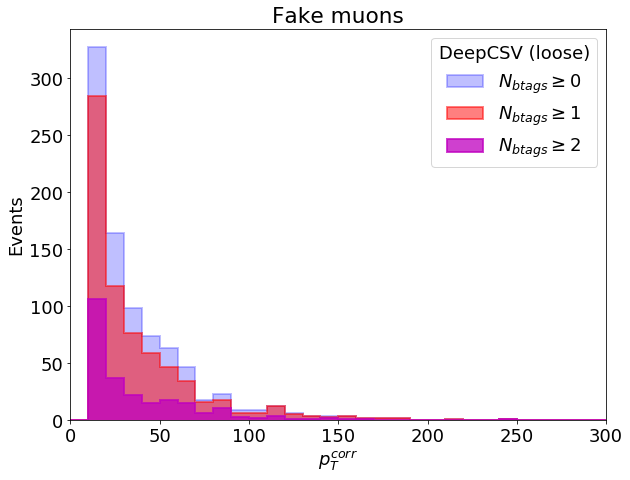

In [247]:
fake_pt_corr_plot(fake_mus_df, "deepCSV", "loose", "muon")

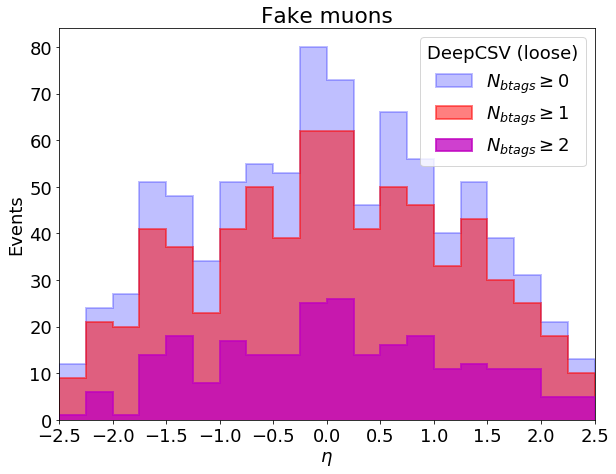

In [248]:
fake_eta_plot(fake_mus_df, "deepCSV", "loose", "muon")

### 4.2 Composition of fakes (DeepCSV medium)

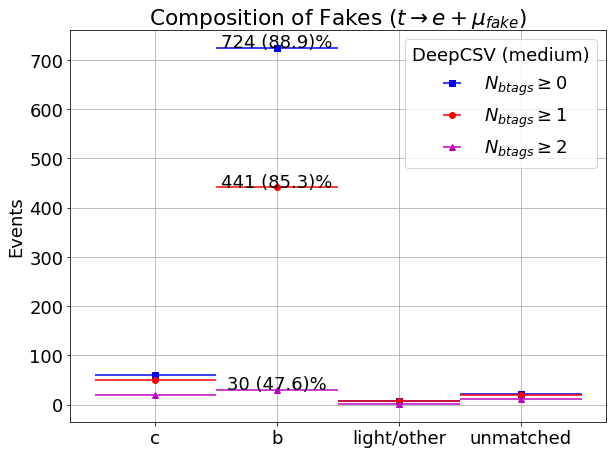

In [249]:
composition_plot(fake_mus_df, "deepCSV", "medium", "muon")

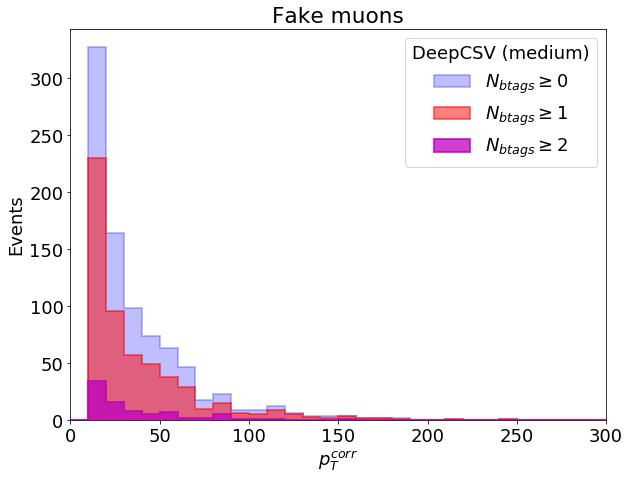

In [250]:
fake_pt_corr_plot(fake_mus_df, "deepCSV", "medium", "muon")

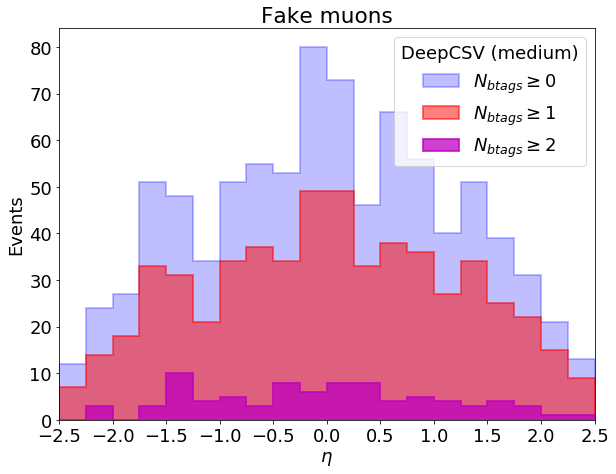

In [251]:
fake_eta_plot(fake_mus_df, "deepCSV", "medium", "muon")

### 4.3 Composition of fakes (DeepCSV tight)

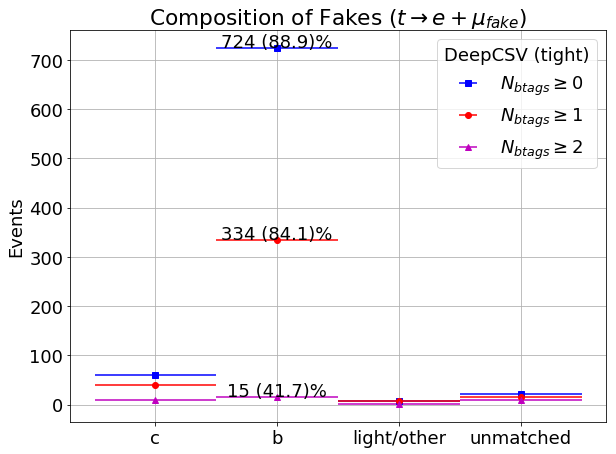

In [252]:
composition_plot(fake_mus_df, "deepCSV", "tight", "muon")

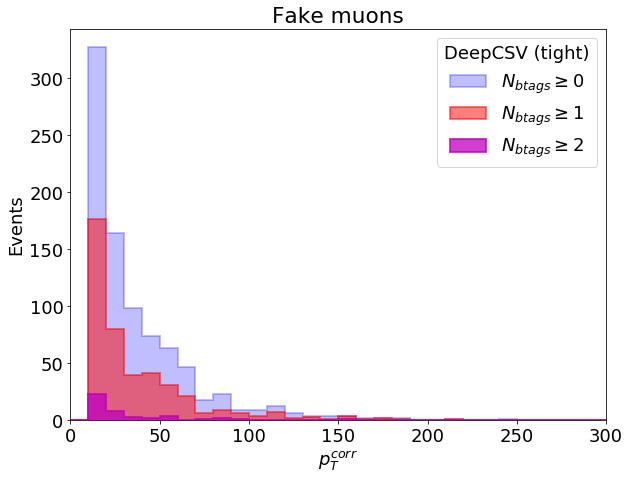

In [253]:
fake_pt_corr_plot(fake_mus_df, "deepCSV", "tight", "muon")

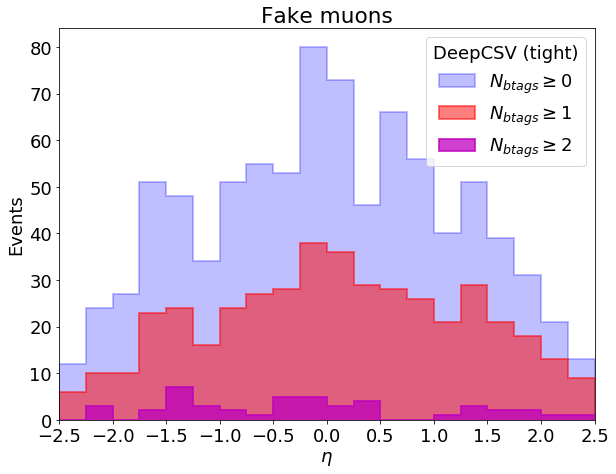

In [254]:
fake_eta_plot(fake_mus_df, "deepCSV", "tight", "muon")

### 4.4 Composition of fakes (DeepJet loose)

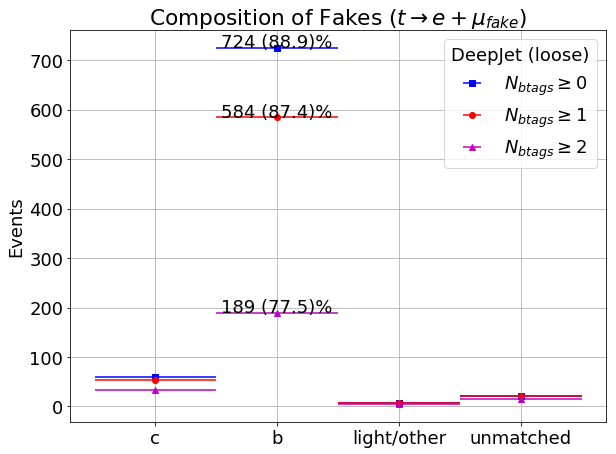

In [255]:
composition_plot(fake_mus_df, "deepJet", "loose", "muon")

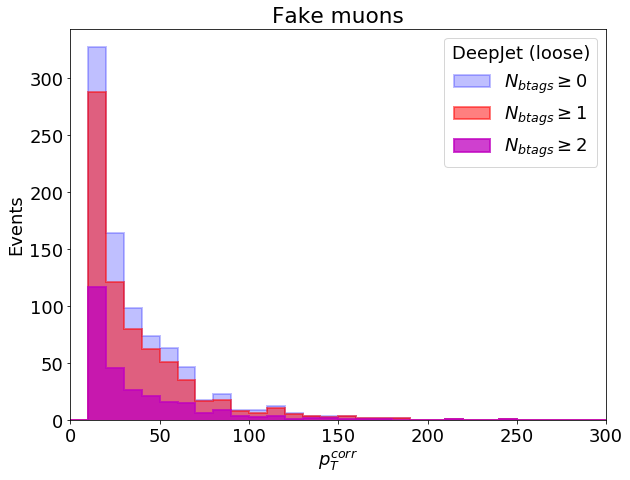

In [256]:
fake_pt_corr_plot(fake_mus_df, "deepJet", "loose", "muon")

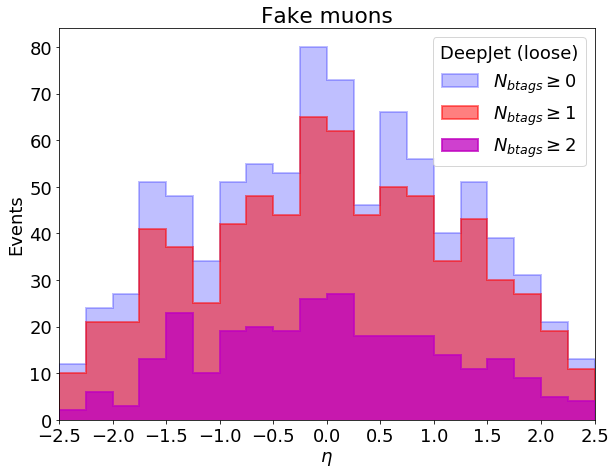

In [257]:
fake_eta_plot(fake_mus_df, "deepJet", "loose", "muon")

### 4.5 Composition of fakes (DeepJet medium)

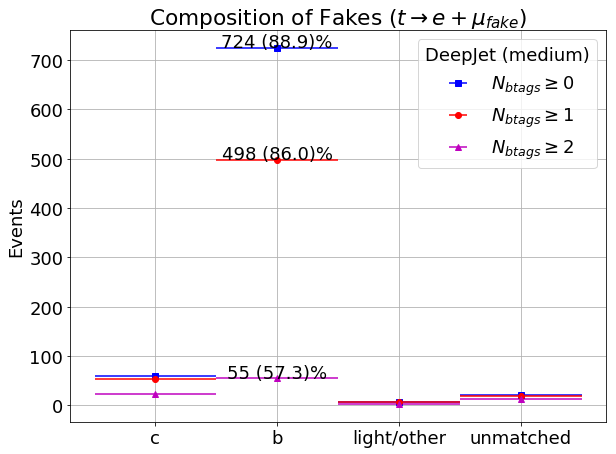

In [258]:
composition_plot(fake_mus_df, "deepJet", "medium", "muon")

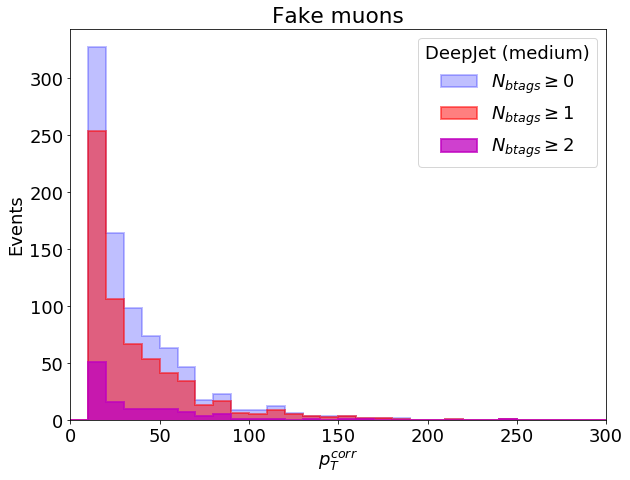

In [259]:
fake_pt_corr_plot(fake_mus_df, "deepJet", "medium", "muon")

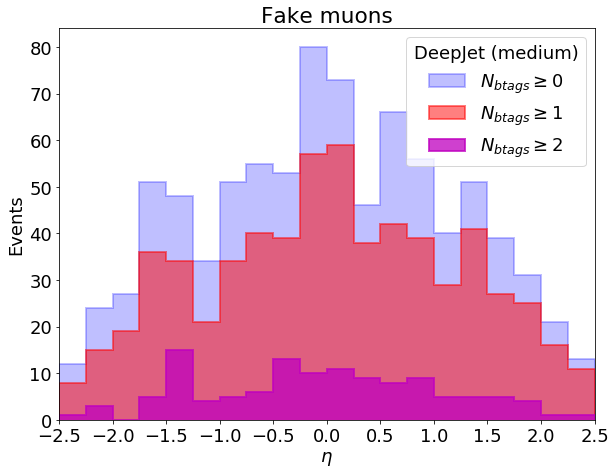

In [260]:
fake_eta_plot(fake_mus_df, "deepJet", "medium", "muon")

### 4.6 Composition of fakes (DeepJet tight)

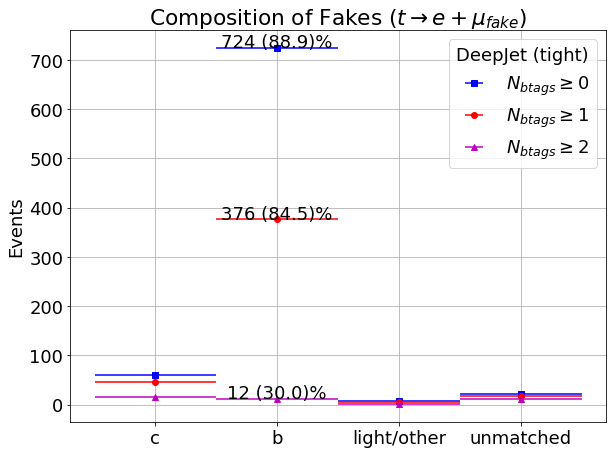

In [261]:
composition_plot(fake_mus_df, "deepJet", "tight", "muon")

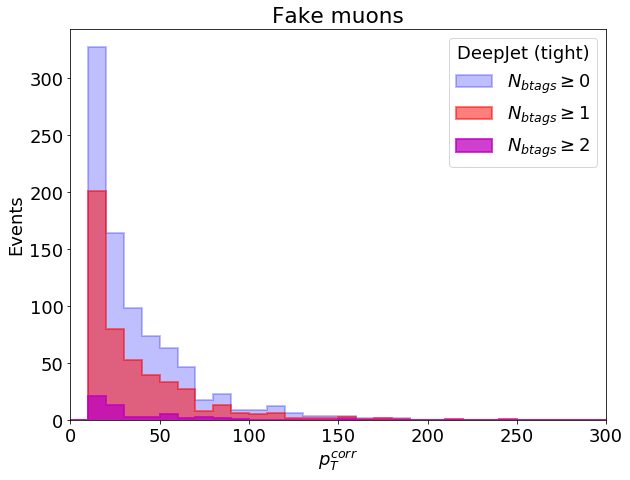

In [262]:
fake_pt_corr_plot(fake_mus_df, "deepJet", "tight", "muon")

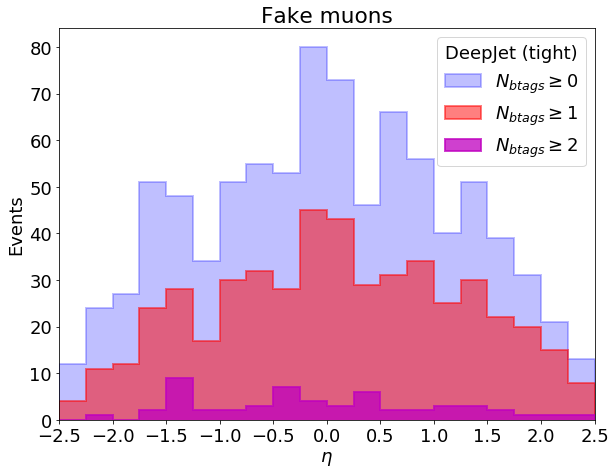

In [263]:
fake_eta_plot(fake_mus_df, "deepJet", "tight", "muon")